In [6]:
import torch

from reggae.utilities import save, load

from reggae.gp.variational.models import NonLinearLFM
from reggae.gp.variational.trainer import Trainer
from reggae.data_loaders import load_humanp53, DataHolder, scaled_barenco_data
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([22, 13])


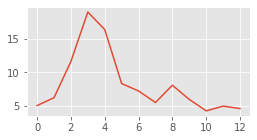

In [7]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]

m_observed, f_observed, t = load_humanp53('../data/', target_genes)

replicate = 0

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)[replicate]

print(m_observed.shape)

num_genes = m_observed.shape[0]
num_tfs = 1
t_inducing = torch.linspace(f64(0), f64(1), 5, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(f64(0), f64(1), 13)
plt.figure(figsize=(4, 2))
plt.plot(m_observed[4])

In [8]:

def plot_genes(rtol=1e-4, atol=1e-6):
    t_predict = torch.linspace(f64(0), f64(1), 80)
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64

    # output_obs, _ = model(t_observed.view(-1), initial_value, rtol=rtol, atol=atol)
    # output_obs = torch.squeeze(output_obs).detach()
    # plt.plot(t_observed, output_obs[0])
    # plt.scatter(t_observed, m_observed[0][0])

    outputs, _ = model(t_predict.view(-1), initial_value, rtol=rtol, atol=atol, num_samples=1)

    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 1.4 * num_genes))
    for i in range(num_genes):
        plt.subplot(num_genes, 1, 1+i)
        plt.plot(t_predict, torch.squeeze(outputs[i]).detach())
        plt.scatter(t_observed, m_observed[i])


In [9]:
model = NonLinearLFM(num_genes, num_tfs, t_inducing, t_observed, known_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

# list(model.parameters())
print(t_observed.shape, m_observed.shape)

torch.Size([13]) torch.Size([22, 13])


C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


### Outputs prior to training:

torch.Size([22, 80])


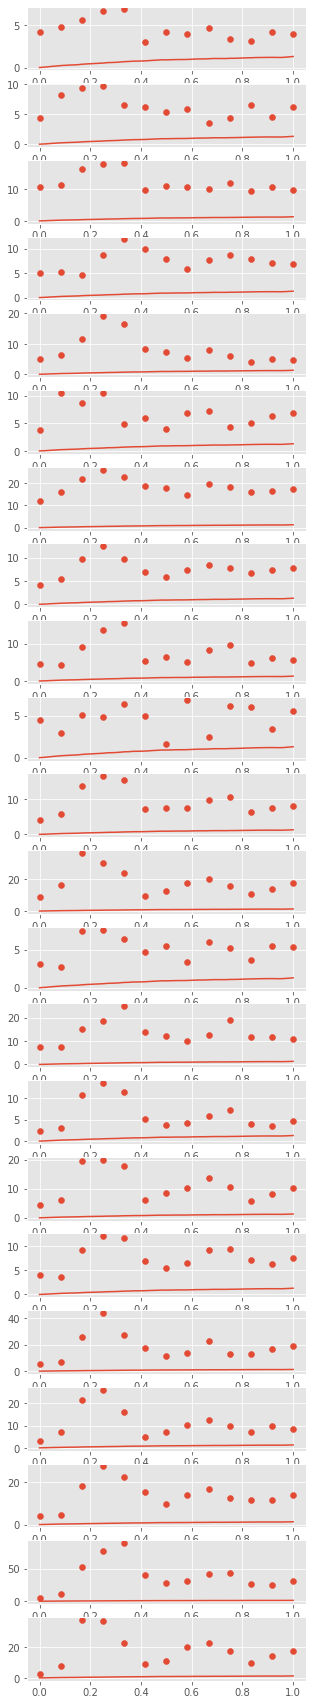

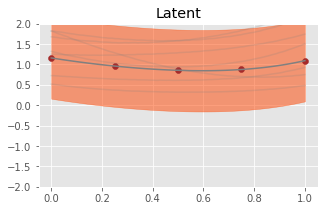

In [10]:
plotter = Plotter(model, m_df.index, t_inducing)
plot_genes(rtol=1e-3, atol=1e-4)
plotter.plot_tfs()

In [ ]:
tol = 1e-3
# trainer = Trainer(optimizer)
output = trainer.train(15, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2)

Epoch 16/30 - Loss: 73767.49 (73737.21 30.28) [3.30,2.50,2.55] b: 1.15 d 1.25 s 2.52 λ: 0.262
Epoch 17/30 - Loss: 69845.58 (69818.83 26.75) [3.46,2.52,2.57] b: 1.11 d 1.39 s 2.42 λ: 0.228
Epoch 18/30 - Loss: 68081.81 (68057.69 24.12) [3.60,2.52,2.58] b: 1.07 d 1.53 s 2.34 λ: 0.201
Epoch 19/30 - Loss: 64076.66 (64054.49 22.17) [3.75,2.50,2.56] b: 1.03 d 1.64 s 2.27 λ: 0.179
Epoch 20/30 - Loss: 61244.84 (61223.78 21.06) [3.89,2.48,2.54] b: 1.01 d 1.75 s 2.21 λ: 0.163
Epoch 21/30 - Loss: 59270.35 (59249.74 20.61) [4.02,2.44,2.51] b: 0.99 d 1.84 s 2.18 λ: 0.150


### Outputs after training

torch.Size([22, 80])


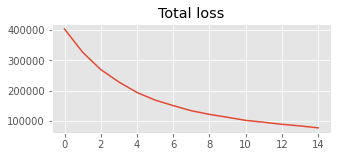

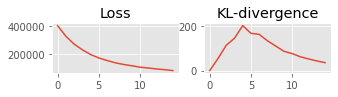

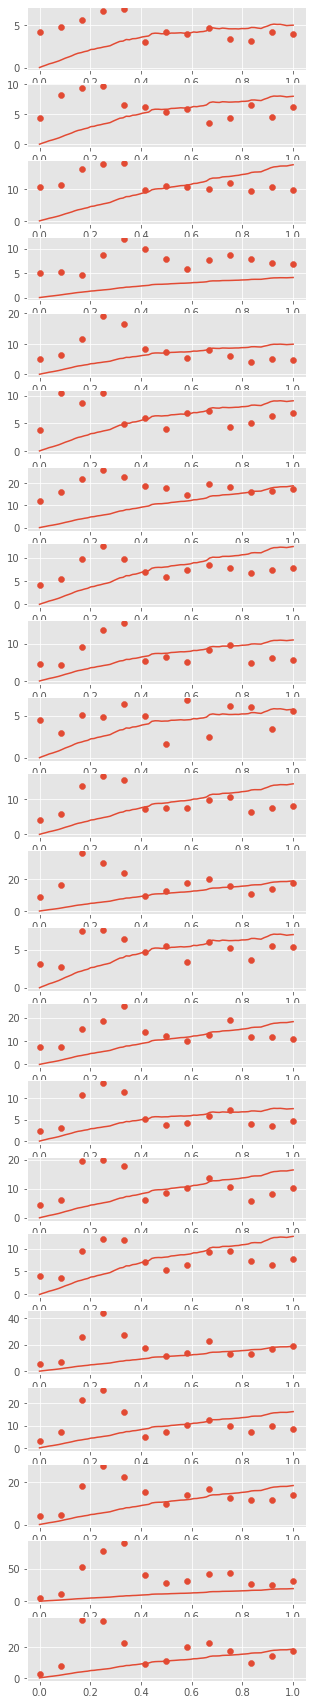

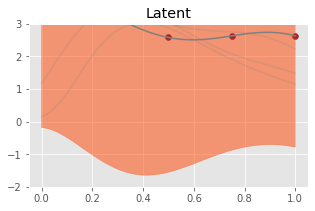

In [12]:
plotter = Plotter(model, m_df.index, t_inducing)

tol = 1e-3
plotter.plot_losses(trainer)
plot_genes(rtol=tol, atol=tol/10)
plotter.plot_tfs(ylim=(-1, 5))


In [255]:
save()

In [260]:
model = load()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(optimizer)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
plt.figure(figsize=(5, 6))
basals = np.array(trainer.basalrates)
decays = np.array(trainer.decayrates)
lengthscales = np.array(trainer.lengthscales)
print(lengthscales.shape)
plt.subplot(311)
# print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

print(model.basal_rate)


In [217]:
model.sensitivity
model.decay_rate
# model.gp.covar_module.outputscale

Parameter containing:
tensor([[0.9056],
        [1.5209],
        [1.2982],
        [0.8000],
        [1.1355]], dtype=torch.float64, requires_grad=True)